In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split # Keep if other models might be used, else not strictly needed for this flow
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_curve, auc, ConfusionMatrixDisplay)
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.initializers import he_normal

In [3]:
np.random.seed(1635848)
tf.random.set_seed(1635848) # Also set TF's random seed for Keras

# NOTE: Based on your script, you've swapped the traditional roles of these files.
# KDDTrain+.txt will be used for actual training, KDDTest+.txt for testing/validation.
# To avoid confusion later, we'll load them into variables reflecting their role.
file_path_actual_train = '/Users/veeshal/Downloads/archive(1)/KDDTrain+.txt'
file_path_actual_test = '/Users/veeshal/Downloads/archive(1)/KDDTest+.txt'

df_train_orig = pd.read_csv(file_path_actual_train)
df_test_orig = pd.read_csv(file_path_actual_test)

columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land',
            'wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised',
            'root_shell','su_attempted','num_root','num_file_creations','num_shells',
            'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count',
            'srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
            'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
            'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
            'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
            'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',
            'attack','level'])

df_train_orig.columns = columns
df_test_orig.columns = columns

print("Original training data (KDDTrain+) shape:", df_train_orig.shape)
print("Original test data (KDDTest+) shape:", df_test_orig.shape)
pd.set_option('display.max_columns', None) # Show all columns

Original training data (KDDTrain+) shape: (125972, 43)
Original test data (KDDTest+) shape: (22543, 43)


In [4]:
categorical_columns = ['protocol_type', 'service', 'flag']

df_train = df_train_orig.copy()
df_test = df_test_orig.copy()


le_map = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    
    df_test[col] = df_test[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1) 

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


train_cat_features_ohe = ohe.fit_transform(df_train_orig[categorical_columns])
ohe_feature_names = ohe.get_feature_names_out(categorical_columns)
df_train_ohe = pd.DataFrame(train_cat_features_ohe, columns=ohe_feature_names, index=df_train.index)

test_cat_features_ohe = ohe.transform(df_test_orig[categorical_columns])
df_test_ohe = pd.DataFrame(test_cat_features_ohe, columns=ohe_feature_names, index=df_test.index) 
df_train = df_train.drop(columns=categorical_columns).join(df_train_ohe)
df_test = df_test.drop(columns=categorical_columns).join(df_test_ohe)

print("Shape of training data after OHE:", df_train.shape)
print("Shape of test data after OHE:", df_test.shape)

attack_mapping = {
    'normal': 0, 'neptune': 1, 'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,
    'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
    'ipsweep': 2, 'nmap': 2, 'portsweep': 2, 'satan': 2, 'mscan': 2, 'saint': 2,
    'ftp_write': 3, 'guess_passwd': 3, 'imap': 3, 'multihop': 3, 'phf': 3, 'spy': 3,
    'warezclient': 3, 'warezmaster': 3, 'sendmail': 3, 'named': 3, 'snmpgetattack': 3,
    'snmpguess': 3, 'xlock': 3, 'xsnoop': 3, 'httptunnel': 3,
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4, 'ps': 4,
    'sqlattack': 4, 'xterm': 4
}
df_train['attack'] = df_train['attack'].replace(attack_mapping)
df_test['attack'] = df_test['attack'].replace(attack_mapping)


Shape of training data after OHE: (125972, 124)
Shape of test data after OHE: (22543, 124)


In [5]:
# Filter for DoS (1) vs Normal (0)
# Ensure 'attack' column is numeric after mapping; handle any non-mapped strings if necessary
df_train['attack'] = pd.to_numeric(df_train['attack'], errors='coerce')
df_test['attack'] = pd.to_numeric(df_test['attack'], errors='coerce')
df_train.dropna(subset=['attack'], inplace=True) # Drop rows where attack type wasn't in mapping
df_test.dropna(subset=['attack'], inplace=True)
df_train['attack'] = df_train['attack'].astype(int)
df_test['attack'] = df_test['attack'].astype(int)


dos_train_df = df_train[df_train['attack'].isin([0, 1])].copy()
dos_test_df = df_test[df_test['attack'].isin([0, 1])].copy()

X_train_dos_full = dos_train_df.drop(columns=['attack', 'level'])
y_train_dos = dos_train_df['attack']

X_test_dos_full = dos_test_df.drop(columns=['attack', 'level'])
y_test_dos = dos_test_df['attack']

print("DoS Training Features shape:", X_train_dos_full.shape)
print("DoS Test Features shape:", X_test_dos_full.shape)

# Feature Alignment (Post-OHE, Pre-Scaling)
# Ensure test set has same columns as training set (and in same order)
train_cols = X_train_dos_full.columns
X_test_dos_full_aligned = X_test_dos_full.reindex(columns=train_cols, fill_value=0)

print("Aligned DoS Test Features shape:", X_test_dos_full_aligned.shape) # Should match X_train_dos_full.shape[1]

# Scaling
scaler = StandardScaler()
X_train_dos_scaled = scaler.fit_transform(X_train_dos_full)
X_test_dos_scaled = scaler.transform(X_test_dos_full_aligned) # Use aligned test set

DoS Training Features shape: (113269, 122)
DoS Test Features shape: (17170, 122)
Aligned DoS Test Features shape: (17170, 122)


In [6]:
N_FEATURES_TO_SELECT = 13
rfe_estimator = DecisionTreeClassifier(random_state=1635848)
rfe = RFE(estimator=rfe_estimator, n_features_to_select=N_FEATURES_TO_SELECT, step=1)

print(f"Performing RFE to select {N_FEATURES_TO_SELECT} features from training data...")
rfe.fit(X_train_dos_scaled, y_train_dos)

# Get selected feature names
selected_feature_indices = rfe.support_
selected_feature_names = X_train_dos_full.columns[selected_feature_indices]
print("Selected features by RFE:", selected_feature_names.tolist())

# Create DataFrames with scaled data to select features by name easily
X_train_dos_scaled_df = pd.DataFrame(X_train_dos_scaled, columns=X_train_dos_full.columns)
X_test_dos_scaled_df = pd.DataFrame(X_test_dos_scaled, columns=X_train_dos_full.columns) # Use same columns as train

# Select RFE features from scaled data
X_train_rfe = X_train_dos_scaled_df[selected_feature_names].values
X_test_rfe = X_test_dos_scaled_df[selected_feature_names].values

print("Shape of training data after RFE:", X_train_rfe.shape)
print("Shape of test data after RFE:", X_test_rfe.shape)

Performing RFE to select 13 features from training data...
Selected features by RFE: ['src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 'same_srv_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_ecr_i', 'flag_RSTR', 'flag_S0']
Shape of training data after RFE: (113269, 13)
Shape of test data after RFE: (17170, 13)


In [7]:
X_train_reshaped = X_train_rfe.reshape(X_train_rfe.shape[0], X_train_rfe.shape[1], 1)
X_test_reshaped = X_test_rfe.reshape(X_test_rfe.shape[0], X_test_rfe.shape[1], 1)

In [8]:
initial_learning_rate = 0.001
def lr_schedule(epoch):
    return initial_learning_rate * (0.1 ** (epoch // 20)) # Adjusted decay frequency

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)
model_checkpoint = ModelCheckpoint(
    filepath='/Users/veeshal/A-Hybrid-CNN-LSTM-Approach-for-Intelligent-Cyber-Intrusion-Detection-System/cnnlstm_dos_model_best.keras',
    verbose=1, save_best_only=True, monitor='val_accuracy', mode='max'
)
callbacks_list = [model_checkpoint, early_stopping, lr_scheduler]

In [10]:
model = Sequential(name="CNN_LSTM_DoS_Detector")
input_shape_cnn = (X_train_reshaped.shape[1], X_train_reshaped.shape[2]) # (13, 1)

model.add(Input(shape=input_shape_cnn))
model.add(Conv1D(64, 3, padding="same", activation='relu', kernel_initializer=he_normal))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25)) # Slightly increased dropout

model.add(Conv1D(128, 3, padding="same", activation='relu', kernel_initializer=he_normal))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.35))
# Check if pool_size makes sense for the length after convolutions
# After 2 pooling layers with size 2, sequence length 13 -> 13/2 = 6 -> 6/2 = 3.
# If it becomes too small (e.g., 1), a third pooling might not be useful or error out.
# Current: 13 -> Conv -> Pool(2) [len 6] -> Conv -> Pool(2) [len 3]
# Adding another pooling layer makes length 3 -> Pool(2) [len 1]
if X_train_reshaped.shape[1] // 4 > 1: # Check if sequence length after two poolings is > 1
    model.add(Conv1D(256, 3, padding="same", activation='relu', kernel_initializer=he_normal))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2)) # This might reduce seq_len to 1 if it was 3
    model.add(Dropout(0.45))
else:
    print("Skipping third Conv-Pool block as sequence length would be too small.")


model.add(LSTM(units=128, dropout=0.25, recurrent_dropout=0.25, return_sequences=False)) # Adjusted LSTM units
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=l2(0.005))) # Adjusted L2

In [11]:
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "CNN_LSTM_DoS_Detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 13, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 3, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,561 (1.23 MB)

 Trainable params: 321,665 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)

In [12]:
print("\nStarting model training...")
history = model.fit(
    X_train_reshaped, y_train_dos,
    epochs=50, # Reduced epochs for quicker run, adjust as needed
    batch_size=512, # Adjusted batch size
    validation_data=(X_test_reshaped, y_test_dos),
    callbacks=callbacks_list,
    verbose=1
)



Starting model training...

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9571 - loss: 0.1519
Epoch 1: val_accuracy improved from -inf to 0.87665, saving model to /Users/veeshal/A-Hybrid-CNN-LSTM-Approach-for-Intelligent-Cyber-Intrusion-Detection-System/cnnlstm_dos_model_best.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.9573 - loss: 0.1513 - val_accuracy: 0.8766 - val_loss: 0.4981 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9863 - loss: 0.0499
Epoch 2: val_accuracy improved from 0.87665 to 0.87699, saving model to /Users/veeshal/A-Hybrid-CNN-LSTM-Approach-for-Intelligent-Cyber-Intrusion-Detection-System/cnnlstm_dos_model_best.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.9863 - loss: 0.0499 - val_accuracy: 0.8770 - val_loss: 0.5843 - learning_rate: 0.0010

Ep


Epoch 18: LearningRateScheduler setting learning rate to 0.001.
Epoch 18/50
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9958 - loss: 0.0178
Epoch 18: val_accuracy did not improve from 0.92557
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9958 - loss: 0.0178 - val_accuracy: 0.9246 - val_loss: 0.4816 - learning_rate: 0.0010

Epoch 19: LearningRateScheduler setting learning rate to 0.001.
Epoch 19/50
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9956 - loss: 0.0182
Epoch 19: val_accuracy did not improve from 0.92557
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.9956 - loss: 0.0182 - val_accuracy: 0.9242 - val_loss: 0.4871 - learning_rate: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.001.
Epoch 20/50
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9958 - loss: 0.0176
Epoch 20: val_accuracy improved from 0.92557 to 0.92568, saving model to /Users/veeshal/A-Hybrid-CNN-LSTM-Approach-for-Intelligent-Cyber-Intrusion-Dete

In [13]:
print("\nLoading best model for evaluation...")
best_model = load_model('/Users/veeshal/A-Hybrid-CNN-LSTM-Approach-for-Intelligent-Cyber-Intrusion-Detection-System/cnnlstm_dos_model_best.keras')

y_pred_proba = best_model.predict(X_test_reshaped)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report (on KDDTest+ data):")
print(classification_report(y_test_dos, y_pred_binary, target_names=['Normal (0)', 'DoS (1)']))


Loading best model for evaluation...
537/537 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Classification Report (on KDDTest+ data):
              precision    recall  f1-score   support

  Normal (0)       0.89      0.99      0.94      9711
     DoS (1)       0.99      0.84      0.91      7459

    accuracy                           0.93     17170
   macro avg       0.94      0.92      0.92     17170
weighted avg       0.93      0.93      0.92     17170



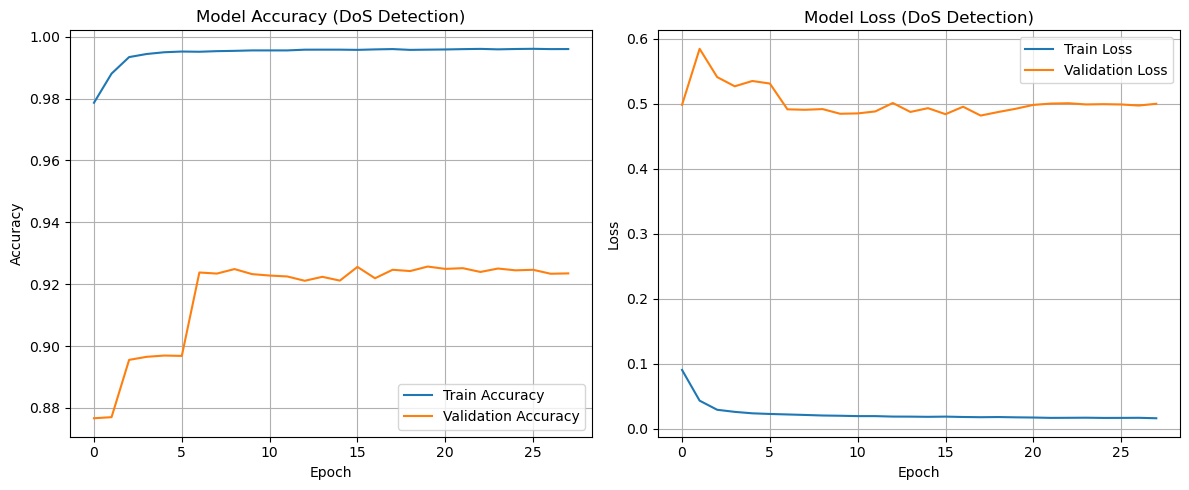

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (DoS Detection)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (DoS Detection)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('training_history_dos_ref.png')
plt.show()


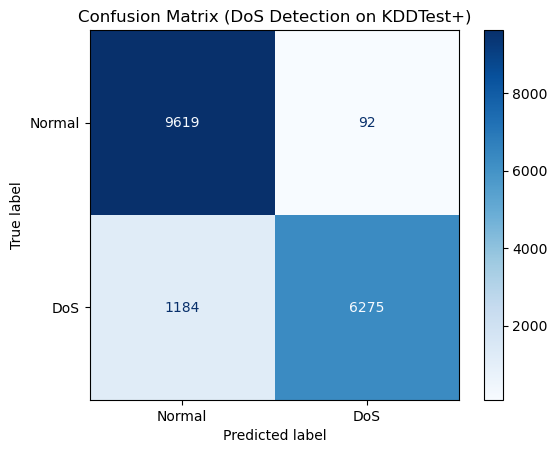

In [15]:
cm = confusion_matrix(y_test_dos, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'DoS'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (DoS Detection on KDDTest+)')
plt.savefig('confusion_matrix_dos_ref.png')
plt.show()

In [16]:
import joblib
import json

# ... (your existing training code) ...

# --- 8. SAVE ARTIFACTS FOR FRONTEND ---
print("\nSaving artifacts for frontend deployment...")

# 1. Save the best Keras model (already done by ModelCheckpoint, but good to have a final explicit save if needed)
# best_model.save('cnnlstm_dos_model_final.keras') # Or use the one from ModelCheckpoint

# 2. Save the StandardScaler
joblib.dump(scaler, 'scaler_dos.pkl')
print("Scaler saved as scaler_dos.pkl")

# 3. Save the OneHotEncoder (ohe object used for categorical_columns)
joblib.dump(ohe, 'ohe_dos.pkl') # Make sure 'ohe' is the OneHotEncoder instance you fitted
print("OneHotEncoder saved as ohe_dos.pkl")

# 4. Save the RFE-selected feature names
with open('rfe_selected_feature_names_dos.json', 'w') as f:
    json.dump(selected_feature_names.tolist(), f) # selected_feature_names from RFE
print("RFE selected features saved to rfe_selected_feature_names_dos.json")

# 5. Save the list of all columns the scaler was trained on (after OHE, before RFE)
# These are the columns of X_train_dos_full
all_scaler_columns = X_train_dos_full.columns.tolist()
with open('all_scaler_columns_dos.json', 'w') as f:
    json.dump(all_scaler_columns, f)
print("All scaler columns saved to all_scaler_columns_dos.json")

# 6. Save the original categorical column names
# categorical_columns = ['protocol_type', 'service', 'flag'] (defined earlier)
with open('categorical_column_names.json', 'w') as f:
    json.dump(categorical_columns, f)
print("Categorical column names saved to categorical_column_names.json")

print("\nArtifact saving complete.")


Saving artifacts for frontend deployment...
Scaler saved as scaler_dos.pkl
OneHotEncoder saved as ohe_dos.pkl
RFE selected features saved to rfe_selected_feature_names_dos.json
All scaler columns saved to all_scaler_columns_dos.json
Categorical column names saved to categorical_column_names.json

Artifact saving complete.
